In [1]:
from model.fdnunet import FDNUNet

import torch
import torch.nn.functional as F
from torch import Tensor

from pathlib import Path
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import accelerate
from accelerate import Accelerator
from ema_pytorch import EMA

/home/namanwsl/anaconda3/envs/fea/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = FDNUNet(
    input_dim=64,
    num_channels=2, # geometry/displacement (2)
    # num_condition_channels=1, # geometry (1)
    num_auxiliary_condition_channels=3, # constraints (1) + force (2)
    num_stages=4
)

In [3]:
def normalize_by_division(tensor: Tensor, value: float) -> Tensor:
        return tensor / value

def normalize_to_negative_one_to_one(tensor: Tensor) -> Tensor:
    return tensor * 2.0 - 1.0

def unnormalize_from_negative_one_to_one(tensor: Tensor) -> Tensor:
        return (tensor + 1.0) / 2.0

In [4]:
image_size = 256

In [5]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.Grayscale(),
        # transforms.RandomHorizontalFlip() if self.augmentation else transforms.Lambda(lambda x: x),
        # transforms.RandomVerticalFlip() if self.augmentation else transforms.Lambda(lambda x: x),
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: normalize_by_division(x, 255.0)),
        transforms.Lambda(lambda x: TF.invert(x)),
    ]
)

In [6]:
path =  Path('')

In [7]:
geometry = normalize_to_negative_one_to_one(
    transform(Image.open(path / "testgeometry.png")) * 0.5
)
geometry = torch.cat((geometry, geometry), dim=0).unsqueeze(0)
constraints = [
    transform(Image.open(path / "testconstraint.png")),
]
constraints = normalize_to_negative_one_to_one(
    F.threshold(
        torch.clamp(
            255 * torch.sum(torch.stack(constraints, dim=0), dim=0),
            min=0,
            max=1.0,
        ),
        0.5,
        0.0,
    ).int()
).float().unsqueeze(0)

magnitudes = [("testload.png", (0, 2700))]
forces = []

for name, values in magnitudes:
    force_tensor = transform(Image.open(path / str(name)))
    force_tensor = torch.clamp(255 * force_tensor, min=0, max=1.0)
    normalized_magnitude = tuple(
        map(
            lambda value: np.sign(value) * ((float(abs(value)) - 0) / (5000 - 0)),
            values,
        )
    )
    forces.append(
        torch.cat(
            (
                force_tensor * normalized_magnitude[0],
                force_tensor * normalized_magnitude[1],
            ),
            dim=0,
        )
    )

forces = torch.clamp(torch.sum(torch.stack(forces, dim=0), dim=0), min=-1.0, max=1.0).unsqueeze(0)

In [8]:
device = torch.device("cpu")

In [9]:
ema_model = EMA(model)

In [10]:
# checkpoint = torch.load("results/model-186/custom_checkpoint_0.pkl", map_location=device)
# print(checkpoint.keys())
# accelerate.load_checkpoint_in_model(ema_model, "results/model-213/custom_checkpoint_0.pkl")
accelerate.load_checkpoint_in_model(model, "results/model-213")

In [11]:
conditions = torch.cat((forces, constraints), dim=1)
# ema_model.ema_model.to(device)
model.to(device)
# prediction = ema_model.ema_model(geometry.to(device), conditions.to(device))
prediction = model(geometry.to(device), conditions.to(device))
prediction = unnormalize_from_negative_one_to_one(prediction) * unnormalize_from_negative_one_to_one(geometry)

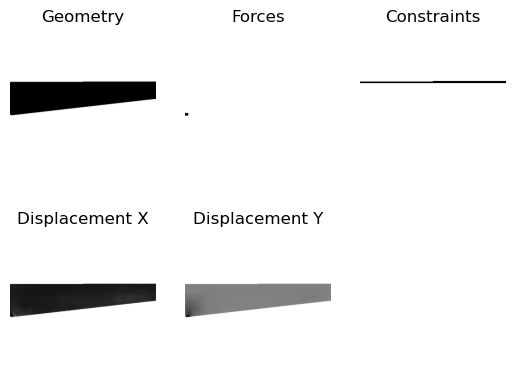

In [12]:
figure = plt.figure()
figure.add_subplot(2, 3, 1)
plt.axis("off")
plt.title("Geometry")
plt.imshow(unnormalize_from_negative_one_to_one(geometry[0, 0, :, :].detach().numpy()), cmap="Greys")
figure.add_subplot(2, 3, 2)
plt.axis("off")
plt.title("Forces")
plt.imshow(unnormalize_from_negative_one_to_one(forces[0, 1, :, :].detach().numpy()), cmap="Greys")
figure.add_subplot(2, 3, 3)
plt.axis("off")
plt.title("Constraints")
plt.imshow(unnormalize_from_negative_one_to_one(constraints[0, 0, :, :].detach().numpy()), cmap="Greys")
figure.add_subplot(2, 3, 4)
plt.axis("off")
plt.title("Displacement X")
plt.imshow(prediction[0, 0, :, :].detach().numpy(), cmap="Greys")
figure.add_subplot(2, 3, 5)
plt.axis("off")
plt.title("Displacement Y")
plt.imshow(prediction[0, 1, :, :].detach().numpy(), cmap="Greys")